In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# pyqubo imports
from pyqubo import Binary, Array

#myqlm imports
from qat.core import Observable, Term
from qat.lang import qrout, H, CNOT, RZ, RX
from qat.lang.AQASM import Program
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin

import networkx as nx

/home/omp/anaconda3/envs/QML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Problema do K-Clique

O Problema do K-Clique consiste em encontrar um subgrafo completo, $\hat{G}$, composto por $K$ vértices (nós), em um dado grafo $G(V,E)$. Um grafo é completo quando todos os seus vértices nós interconectados. Na figura abaixo, podemos ver um grafo e seu respectivo clique de tamanho $K=4$.

<img src="grafo_clique.png" width=750 />



É possível verificar que o conjunto dos vértices $|V_c| = \{0,1,2,3\} $ formam um clique de tamanho $K=4$, pois formam um grafo completo. 

### Exercício 1:

Vamos codificar o grafo da figura anterior e desenhá-lo usando a framework `Networkx`.
Substitua a resposta correta pelos 2 FIXMEs no código abaixo.

In [2]:
#Criando um grafo G
# crie uma estrutura que codifique o grafo
G = nx.Graph()

# crie uma lista com os indices de cada nó
nodes = [i for i in range(5)]

# crie uma lista de tuplas com os nos vizinhos: g=[..., (ni,nj),...]
g = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4)]

G.add_edges_from(g)
#nx.draw(G, with_labels=True)
print(G)

Graph with 5 nodes and 8 edges


### Exercício 2:

Agora, defina os parâmetros do problema. Note que queremos encontrar um clique de tamanho $K=4$ no grafo dado como exemplo.
Substitua a resposta correta pelos 4 FIXMEs no código abaixo.

In [3]:
# -----------------
# parametros do problema
# -----------------

# defina o tamanho do clique
K= 4
# numero de nos do grafo
num_nodes = len(nodes)
# numero de arestas no clique
E = K*(K-1)//2
# penalidades para Ha e Hb
A,B = 4,1

print(f"Tamanho do Clique: {K}\n Número de nós: {num_nodes}\n Número de arestas no Clique: {E}\n Constantes de penalidade: {A} e {B}.")


Tamanho do Clique: 4
 Número de nós: 5
 Número de arestas no Clique: 6
 Constantes de penalidade: 4 e 1.


## Formulação como Otimização Irrestrita

Formularemos o problema como uma função de otimização com variáveis binárias, $x_i \in \{0,1\}$, sendo que o "estado" de cada vértice é dado por $x_i$. Se $x_i = 1$, indica que o vértice de índice $i$ faz parte do clique. A solução do exemplo com o grafo apresentado anteriormente é dada por $\vec{x} = 11110$, visto que apenas o vértice $4$ não faz parte do clique.

Apresentaremos dois termos de penalidades necessários para escrever o Problema do Clique como Otimização Irrestrita. Um dos termos está relacionado ao fato de que o número de vértices no estado $x_i = 1$ deve ser igual a $K$. Para isso, criamos o termo

$$ H_a = \left(K - \sum_{i=0}^{N}x_i\right)^2. $$

Quanto maior a diferença entre $K$ e o número de vértices em estado $1$, maior será a penalidade na função objetivo. O valor de $H_a$ será $0$ (mínimo) quando o critério for atendido. 

### Exercício 3a:

Escreva o termo $H_a$ da função objetivo em termos das variáveis binárias `Binary('xi')` do Pyqubo.

In [4]:
# ----------------------------------------
# criando as variaveis binarias com pyqubo
# ----------------------------------------

# criando o termo Ha
variables = Array.create('x', shape=num_nodes, vartype='BINARY')
x_sum = sum(variables) 

Ha = (K - x_sum)**2
Ha

((4.000000 + (-1.000000 * (Binary('x[4]') + Binary('x[3]') + Binary('x[2]') + Binary('x[1]') + 0.000000 + Binary('x[0]')))) * (4.000000 + (-1.000000 * (Binary('x[4]') + Binary('x[3]') + Binary('x[2]') + Binary('x[1]') + 0.000000 + Binary('x[0]')))))

Contudo, claramente, essa condição não é suficiente para garantir que o clique seja encontrado. Para isso, introduziremos outros conceitos, começando pela quantidade de arestas em um clique. Essa quantidade é dada por

$$E = \frac{K(K-1)}{2}.$$

Logo, introduziremos um novo termo na função objetivo, cujo papel desempenhado é o de penalizar a função caso o número de arestas do subgrafo que conectam os nós de estado $x_i = 1$ seja diferente de $E$. Queremos que a quantidade de arestas do clique seja igual a $E$, logo, criamos o seguinte termo:

$$H_b = E - \sum_{<ij>}x_ix_j$$
onde $<ij>$ representa os índices apenas dos vértices conectados entre si. 

### Exercício 3b:

Escreva o termo $H_b$ da função objetivo em termos das variáveis binárias `Binary('xi')` do Pyqubo.

In [5]:
# criando o termo Hb
quadratic_terms_sum = sum([variables[edge[0]]*variables[edge[1]] for edge in g])

Hb = E - quadratic_terms_sum
Hb

(6.000000 + (-1.000000 * ((Binary('x[3]') * Binary('x[4]')) + (Binary('x[2]') * Binary('x[4]')) + (Binary('x[2]') * Binary('x[3]')) + (Binary('x[1]') * Binary('x[3]')) + (Binary('x[1]') * Binary('x[2]')) + (Binary('x[0]') * Binary('x[3]')) + (Binary('x[0]') * Binary('x[2]')) + 0.000000 + (Binary('x[0]') * Binary('x[1]')))))

Introduziremos ainda as variáveis de penalidade dadas por $A$ e $B$, que são números inteiros usados para controlar a função objetivo e garantir que as restrições serão atendidas. Sendo assim, a função objetivo final é dada por 

$$H = A\left(K - \sum_{i=0}^{N}x_i\right)^2 + B\left( C - \sum_{<ij>}x_ix_j\right).$$

Neste problema, devemos considerar as constantes de penalidade satisfaznedo $A > B$.

### Exercício 3c:

Escreva a função objetivo inteira juntando os termos $H_a$ e $H_b$ com suas variáveis de penalidade.

In [6]:
# escreva a função objetivo
Hamil = A*Ha + B*Hb

model = Hamil.compile()
qubo = model.to_qubo()
print(qubo)

({('x[4]', 'x[0]'): 8.0, ('x[0]', 'x[0]'): -28.0, ('x[3]', 'x[1]'): 7.0, ('x[3]', 'x[0]'): 7.0, ('x[4]', 'x[4]'): -28.0, ('x[4]', 'x[2]'): 7.0, ('x[4]', 'x[1]'): 8.0, ('x[4]', 'x[3]'): 7.0, ('x[3]', 'x[2]'): 7.0, ('x[3]', 'x[3]'): -28.0, ('x[2]', 'x[2]'): -28.0, ('x[1]', 'x[1]'): -28.0, ('x[2]', 'x[1]'): 7.0, ('x[1]', 'x[0]'): 7.0, ('x[2]', 'x[0]'): 7.0}, 70.0)


In [7]:
single_values = {}
multiple_values = {}
for k,v in qubo[0].items():
    if k[0] == k[1]:
        single_values[int(k[0][2])] = v
    else:
        multiple_values[(int(k[0][2]), int(k[1][2]))] = v

num_qubits = num_nodes
hamiltonian_clique = Observable(num_qubits,
                           pauli_terms=
                           [Term(single_values[x], "Z", [x]) for x in single_values]+
                           [Term(multiple_values[x], "ZZ", [x[0],x[1]]) for x in multiple_values],
                           constant_coeff=qubo[1]
                           )

print(hamiltonian_clique)

70.0 * I^5 +
-28.0 * (Z|[0]) +
-28.0 * (Z|[4]) +
-28.0 * (Z|[3]) +
-28.0 * (Z|[2]) +
-28.0 * (Z|[1]) +
8.0 * (ZZ|[4, 0]) +
7.0 * (ZZ|[3, 1]) +
7.0 * (ZZ|[3, 0]) +
7.0 * (ZZ|[4, 2]) +
8.0 * (ZZ|[4, 1]) +
7.0 * (ZZ|[4, 3]) +
7.0 * (ZZ|[3, 2]) +
7.0 * (ZZ|[2, 1]) +
7.0 * (ZZ|[1, 0]) +
7.0 * (ZZ|[2, 0])


## Resolução de um problema de otimização irrestrita com um circuito variacional quântico

## Circuito QAOA

<p align="center">
<img src="qaoa_cirq.png" width="800" />
</p>

### Exercício 4:

Crie o objeto `qaoa`, através da classe SolverQAOA, com seus argumentos declarados corretamente.
Substitua a resposta correta pelos 4 FIXMEs no código abaixo.

In [8]:
#qaoa = SolverQAOA(binary_model = model, num_variables = 5, num_measurements = 1000, depth=4)

### Exercício 5:

Crie o circuito para operador de fase do QAOA e atribua um parametro qualquer no intervalo [0, pi].
Substitua a resposta correta pelo FIXME no código abaixo.

In [9]:
# DICA: os termos do observável podem ser acessados pelo atributo observable.terms
#       Cada termo armazena o tipo de operação em term.ops e os qubits operados em term.qbits
@qrout
def phase_separator(gamma, single_values, multiple_values):
    for i in single_values:
        RZ(gamma)(i[0])
    for j in multiple_values:
        CNOT(j[0], j[1])
        RZ(2*gamma)(j[1])
        CNOT(j[0], j[1])

single_values = [t.qbits for t in hamiltonian_clique.terms if len(t.qbits) == 1]
multiple_values = [t.qbits for t in hamiltonian_clique.terms if len(t.qbits) > 1]
phase_separator(np.pi, single_values, multiple_values).display()

### Exercício 6:

Crie o circuito para operador mixer do QAOA e atribua um parametro qualquer no intervalo [0, pi].
Substitua a resposta correta pelo FIXME no código abaixo.

In [10]:
@qrout
def mixer(beta, num_nodes):
    for i in range(num_nodes):
        RX(beta)(i)

mixer(np.pi, num_nodes).display()

### Exercício 7:

Defina um chute inicial para os parametros variacionais de todo o circuito, baseado na profundidade do circuito `depth`. Através do método `full_circuit_measurements`, crie o circuito completo e as `num_measurements` medidas para o chute incicial.
Substitua a resposta correta pelos 2 FIXMEs no código abaixo.

In [11]:
@qrout
def initial_state(num_qubits):
    for q in range(num_qubits):
        H(q)

initial_state(num_nodes).display()

In [12]:
# --------------------------
# Running QAOA for Clique on simulator
# --------------------------

# -------------------
# Initializing qubits
# -------------------
p = 1
qprog = Program()
qbits = qprog.qalloc(num_qubits)

gamma  = [qprog.new_var(float, '\\gamma_%s'%i) for i in range(1,p+1)]
beta   = [qprog.new_var(float, '\\beta_%s'%i) for i in range(1,p+1)]

# --------------------------
# Initial state preparation
# --------------------------
qprog.apply(initial_state(num_qubits), qbits)

# ----------------------------------
# Alternate application of operators
# ----------------------------------

single_values = [t.qbits for t in hamiltonian_clique.terms if len(t.qbits) == 1]
multiple_values = [t.qbits for t in hamiltonian_clique.terms if len(t.qbits) > 1]

for step in range(p):
    qprog.apply(phase_separator(gamma[step], single_values, multiple_values), qbits)
    qprog.apply(mixer(beta[step], num_qubits), qbits)

In [13]:
circuit = qprog.to_circ()
print("total number of gates: ", len(circuit.ops))
print("Variables:", circuit.get_variables())
# Display quantum circuit
%qatdisplay circuit --svg

total number of gates:  45
Variables: ['\\beta_1', '\\gamma_1']


In [14]:
# Create a job
job = circuit.to_job(observable=hamiltonian_clique)

result_list = []
# Escolha um número de iterações adequado
num_iterations = 50
for _ in range(num_iterations):
    # Inicialize p parâmetros gamma e p parâmetros beta iniciais entre os valores (0, 2*pi)
    initial_parameters = [np.random.uniform(0, 2*np.pi) for _ in range(2*p)]
    cobyla = ScipyMinimizePlugin(tol=1e-6,
                                method="COBYLA",
                                options={"maxiter": 300},
                                x0=initial_parameters)
    # Create a Quantum Processor Unit
    qpu = get_default_qpu()

    stack = cobyla | qpu

    # Submit the job to the QPU
    result_list.append(stack.submit(job))

### Análise dos Resultados

In [15]:
for i, r in enumerate(result_list):
    print("Run", i, ", Final energy:", r.value)
    #Binding the variables:random.uniform(0, 2*np.pi)
    sol_job = job(**eval(r.meta_data["parameter_map"]))

    #Rerunning in 'SAMPLE' mode to get the most probable states:
    sampling_job = sol_job.circuit.to_job()

    sol_res = qpu.submit(sampling_job)
    print("Most probable states are:")
    for sample in sol_res:
        if sample.probability > 0.05:
            print(sample.state, "{:.2f}%".format(100 * sample.probability))

Run 0 , Final energy: 65.92173315215516
Most probable states are:
|00111> 5.16%
|01011> 5.16%
|01101> 5.16%
|01110> 5.16%
|10011> 5.16%
|10101> 5.16%
|10110> 5.16%
|11001> 5.16%
|11010> 5.16%
|11100> 5.16%
Run 1 , Final energy: 65.92173315228138
Most probable states are:
|00111> 5.16%
|01011> 5.16%
|01101> 5.16%
|01110> 5.16%
|10011> 5.16%
|10101> 5.16%
|10110> 5.16%
|11001> 5.16%
|11010> 5.16%
|11100> 5.16%
Run 2 , Final energy: 1.9445030433233512
Most probable states are:
|00000> 93.03%
Run 3 , Final energy: 46.21268081122948
Most probable states are:
|00011> 6.11%
|00101> 6.11%
|00110> 6.11%
|01001> 6.11%
|01010> 6.11%
|01100> 6.11%
|10001> 6.11%
|10010> 6.11%
|10100> 6.11%
|11000> 6.11%
Run 4 , Final energy: 1.9444444557442608
Most probable states are:
|00000> 93.25%
Run 5 , Final energy: 46.21268081096307
Most probable states are:
|00011> 6.11%
|00101> 6.11%
|00110> 6.11%
|01001> 6.11%
|01010> 6.11%
|01100> 6.11%
|10001> 6.11%
|10010> 6.11%
|10100> 6.11%
|11000> 6.11%
Run 6 , Fina

In [16]:
# Escolhendo o resultado com o menor valor esperado
result = min(result_list, key=lambda s: s.value)
print("Final energy:", result.value)
for key, value in result.meta_data.items():
    print(key, ":", value)

Final energy: 1.9444444466959823
optimizer_data :      fun: 1.9444444466959823
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 300
  status: 2
 success: False
       x: array([1.33456891, 1.57079631])
parameters : [1.3345689130141316, 1.5707963066861081]
optimization_trace : [89.65343976931986, 132.0722947190887, 86.70295705725553, 34.94180370265816, 11.75333329562907, 85.94887236669898, 100.83660500209331, 49.077049763898536, 14.24022907605736, 76.36555361967423, 2.392134791504674, 3.6058215318312534, 2.378881395938322, 3.5281143460060775, 4.998047557442277, 1.9821342003561568, 2.015244068536873, 1.982254346891395, 2.0153962432820265, 1.9473513282302548, 2.015411409637295, 1.9683874911118693, 1.9480406927838771, 1.9518104238753295, 1.9463948699969933, 1.9476698025877823, 1.9469383743592061, 1.9460150967631193, 1.9459517250795386, 1.9462290537114058, 1.9457889656739837, 1.9456575948325394, 1.9455646278520646, 1.945449462932828, 1.9453930380

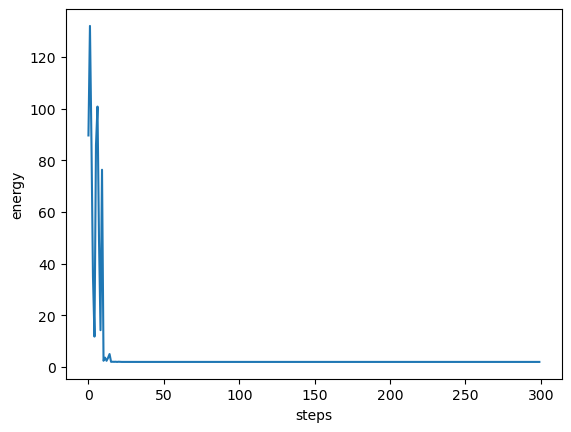

In [17]:
plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("steps")
plt.ylabel("energy")
plt.show()

In [18]:
def clique_obj(eigenstate, qubo):

        """
        Args:
            eigenstate -> binary string 
        Output:
            cost -> cost associated with binary string regarding the QUBO.
        """
        
        #evaluate cost function
        cost = 0
        for key, value in qubo[0].items():
            cost += value * int(eigenstate[int(key[0][2])]) * int(eigenstate[int(key[1][2])])
        
        return cost

In [19]:
# Emulating a reasonable setup:
# Drawing 2048 cuts
sol_job = job(**eval(result.meta_data["parameter_map"]))
sampling_job = sol_job.circuit.to_job(nbshots=2048)
sol_res = qpu.submit(sampling_job)

max_state = max([(s.state.value[0], s.probability) for s in sol_res], key=lambda s: s[1])
print("State with highest probability:"
      , max_state[0]
      , "%.2f%%" % (100 * max_state[1]) )

tuple_list = [(s.state.value[0], s.probability, clique_obj(s.state.value[0],qubo)) for s in sol_res]
print(tuple_list)
clique = min(tuple_list, key=lambda s: s[2])
print(
    "Best answer found:"
    , clique[0]
    , "%.2f%%" % (100 * clique[1]) )

State with highest probability: 00000 92.29%
[('00000', 0.9228515625, 0.0), ('00001', 0.01806640625, -28.0), ('00010', 0.0166015625, -28.0), ('00011', 0.00048828125, -49.0), ('00100', 0.01513671875, -28.0), ('00101', 0.00048828125, -49.0), ('00110', 0.0009765625, -49.0), ('01000', 0.0126953125, -28.0), ('01010', 0.00048828125, -49.0), ('10000', 0.01171875, -28.0), ('10100', 0.00048828125, -49.0)]
Best answer found: 00011 0.05%
